In [1]:
import pandas as pd
import csv
import os
import time
from collections import defaultdict
import numpy as np
import itertools
import db_structure
import networkx as nx
from imp import reload
import matplotlib.pyplot as plt
import utilities as u
from flask import jsonify
import logging
logging.basicConfig(format=' %(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
%load_ext autoreload
%aimport -web
%autoreload 2

In [272]:
db = db_structure.DB(os.path.join('datasets', 'sample1'))
#db.add_global_fks_to_config(["customerNumber","officeCode","productCode","orderNumber"])
#db.add_custom_fk_to_config(table_1_name='employees', table_2_name='customers', column_1_name='employeeNumber', column_2_name='salesRepEmployeeNum')
#db.add_custom_fk_to_config('orders', 'customers', 'customerNum', 'customerNumber')
#db.add_custom_fk_to_config('products', 'productlines', 'productLine', 'ProductLine')
#db.add_custom_column_name_to_config('customers', 'customerNumber', 'Customer Number')
#db.add_custom_column_name_to_config('customers', 'LastName', 'Last Name')
#db.add_custom_column_name_to_config('orders', 'customerNum', 'Customer Num')
#db.finalize_setup()

INFO:root:Loading setup file: datasets\sample1\sample1.setup
DEBUG:root:Linking ['customerNumber', 'officeCode', 'productCode', 'orderNumber'] global_fks
DEBUG:root:Linking custom_fk {'table_1_name': 'employees', 'table_2_name': 'customers', 'column_1_name': 'employeeNumber', 'column_2_name': 'salesRepEmployeeNum'}
DEBUG:root:employees.employeeNumber --> customers.salesRepEmployeeNum
DEBUG:root:Linking custom_fk {'table_1_name': 'orders', 'table_2_name': 'customers', 'column_1_name': 'customerNum', 'column_2_name': 'customerNumber'}
DEBUG:root:orders.customerNum --> customers.customerNumber
INFO:root:Linking to column 0
DEBUG:root:Linking custom_fk {'table_1_name': 'products', 'table_2_name': 'productlines', 'column_1_name': 'productLine', 'column_2_name': 'ProductLine'}
DEBUG:root:products.productLine --> productlines.ProductLine
DEBUG:root:Renaming customers->customerNumber to Customer Number
DEBUG:root:Renaming customers->LastName to Last Name
DEBUG:root:Renaming orders->customerNum

In [279]:
db2 = db_structure.DB(os.path.join('datasets', 'sample2'))
#db2.add_global_fks_to_config(["col2","col6","col1","col5","col4","col7","col3"])
#db2.finalize_setup()

INFO:root:Loading setup file: datasets\sample2\sample2.setup
DEBUG:root:Linking ['col2', 'col6', 'col1', 'col5', 'col4', 'col7', 'col3'] global_fks
DEBUG:root:Loading file A.csv
DEBUG:root:Loading file B.csv
DEBUG:root:Loading file C.csv
DEBUG:root:Loading file D.csv
DEBUG:root:Loading file E.csv
DEBUG:root:Loading file F.csv


In [269]:
db3 = db_structure.DB(os.path.join('datasets', 'TOPICC'))
db3.add_global_fks_to_config(['PudID'])
db3.finalize_setup()

INFO:root:Loading setup file: datasets\TOPICC\TOPICC.setup
DEBUG:root:Linking ['PudID'] global_fks


ERROR:root:Cannot make changes to setup. Run unfinalize_setup() if you want to make changes, and then run finalize_setup when you are finished to generate a new .setup file
ERROR:root:Setup has already been marked as complete


In [275]:
db.tables['customers'].__dict__

{'name': 'customers',
 'df':    customerNumber   LastName FirstName  salesRepEmployeeNum
 0               1        Bob     Billy                    1
 1               2    Jenkins     Sally                    1
 2               3     Hobbes    Calvin                    1
 3               4      Jacob      John                    2
 4               5      Smith     Peter                    3
 5               6  Carpenter     Selma                    3
 6               7     Taylor      Zach                    4
 7               8  Cranberry     Chris                    5
 8               9     Martin      Remy                    5
 9              10  Hollinger  Charlene                    5}

In [295]:
db.struct.__dict__

{'metadata': <db_structure.Metadata at 0xf20f400>,
 'config': <db_structure.Config at 0xf20feb8>,
 'column_factory': <db_structure.ColumnFactory at 0xf1f7550>,
 'column_links': defaultdict(dict,
             {0: {'customers': 'customerNumber',
               'payments': 'customerNumber',
               'orders': 'customerNum'},
              1: {'employees': 'officeCode', 'offices': 'officeCode'},
              2: {'orderdetails': 'productCode', 'products': 'productCode'},
              3: {'orderdetails': 'orderNumber', 'orders': 'orderNumber'},
              4: {'employees': 'employeeNumber',
               'customers': 'salesRepEmployeeNum'},
              5: {'products': 'productLine', 'productlines': 'ProductLine'},
              6: {'customers': 'LastName'},
              7: {'customers': 'FirstName'},
              8: {'employees': 'LastName'},
              9: {'employees': 'FirstName'},
              10: {'offices': 'State'},
              11: {'orderdetails': 'quantity'},
   

In [293]:
db2.get_biggest_joined_df_option('A', 'F')

,col1_[A],col2_[A],col3_[A],col1_[C],col5_[C],col6_[C],col5_[F],col7_[F],col8_[F]
0,1,A,3,1,F,7,F,1,a
1,1,A,4,1,F,7,F,1,a
2,1,B,5,1,F,7,F,1,a
3,2,B,6,2,F,8,F,1,a
4,2,C,7,2,F,8,F,1,a
5,2,C,8,2,F,8,F,1,a


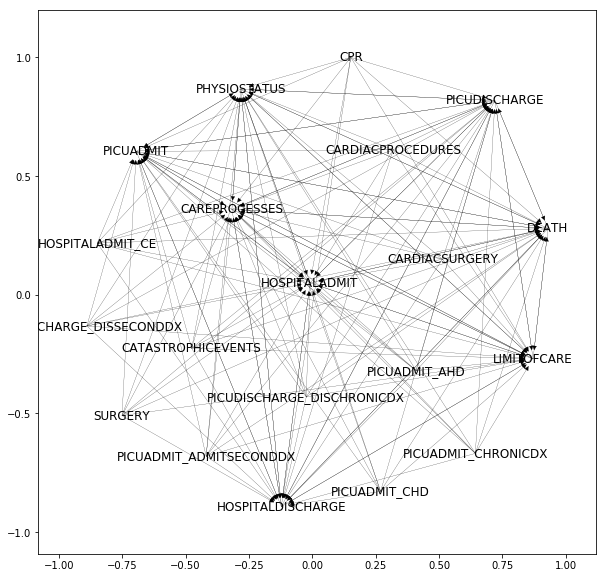

In [270]:
draw_db = db3

G = nx.DiGraph()
G.add_nodes_from(draw_db.metadata.table_names)
for table_name in draw_db.metadata.table_names:
    for sibling in draw_db.struct.table_siblings(table_name):
        G.add_edge(table_name, sibling)
        G.add_edge(sibling, table_name)
    for child in draw_db.struct.table_children(table_name):
        G.add_edge(table_name, child)
plt.figure(figsize=(10,10))

#draw with networkx built-ins
nx.draw_networkx(G, node_shape="None", width=0.2)

#OR

#draw using pygraphviz
#A = nx.nx_agraph.to_agraph(G)
#H = nx.nx_agraph.from_agraph(A)
#nx.draw_spring(H, node_shape="None", with_labels=True, width=0.2)